In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from pprint import pprint

import re

from collections import Counter

import os

from tqdm import tqdm

import tensorflow as tf

# for output_projection
from tensorflow.python.layers.core import Dense
import numpy as np

In [2]:
# maximum length of input and target sentences including paddings
enc_sentence_length = 10
dec_sentence_length = 10

In [3]:
# Batch_size: 2
input_batches = [
    ['Hi What is your name?', 'Nice to meet you!'],
    ['Which programming language do you use?', 'See you later.'],
    ['Where do you live?', 'What is your major?'],
    ['What do you want to drink?', 'What is your favorite beer?']]

target_batches = [
    ['Hi this is Jaemin.', 'Nice to meet you too!'],
    ['I like Python.', 'Bye Bye.'],
    ['I live in Seoul, South Korea.', 'I study industrial engineering.'],
    ['Beer please!', 'Leffe brown!']]

In [4]:
all_input_sentences = []
for input_batch in input_batches:
    all_input_sentences.extend(input_batch)
    
all_target_sentences = []
for target_batch in target_batches:
    all_target_sentences.extend(target_batch)

# Example
all_input_sentences

['Hi What is your name?',
 'Nice to meet you!',
 'Which programming language do you use?',
 'See you later.',
 'Where do you live?',
 'What is your major?',
 'What do you want to drink?',
 'What is your favorite beer?']

In [5]:
def tokenizer(sentence):
    tokens = re.findall(r"[\w]+|[^\s\w]", sentence)
    return tokens

# Example
tokenizer('Hello world?? "sdfs%@#%')

['Hello', 'world', '?', '?', '"', 'sdfs', '%', '@', '#', '%']

In [6]:
def build_vocab(sentences, is_target = False, max_vocab_size = None):
    word_counter = Counter()
    vocab = dict()
    reverse_vocab = dict()
    
    for sentence in sentences:
        tokens = tokenizer(sentence)
        word_counter.update(tokens)
    
    if max_vocab_size is None:
        max_vocab_size = len(word_counter)
    
    if is_target:
        vocab['GO'] = 0
        vocab[' PAD'] = 1
        vocab_idx = 2
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
    else:
        vocab[' PAD'] = 0
        vocab_idx = 1
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
    for key, value in vocab.items():
        reverse_vocab[value] = key
    return vocab, reverse_vocab, max_vocab_size
            

In [7]:
enc_vocab, enc_reverse_vocab, enc_vocab_size = build_vocab(all_input_sentences)
dec_vocab, dec_reverse_vocab, dec_vocab_size = build_vocab(all_target_sentences, is_target=True)

print('input vocabulary size:', enc_vocab_size)
print('target vocabulary size:', dec_vocab_size)

input vocabulary size: 26
target vocabulary size: 28


In [8]:
def token2idx(word, vocab):
    return vocab[word]

In [9]:
def sent2idx(sent, vocab = enc_vocab, max_sentence_length = enc_sentence_length, is_target = False ):
    tokens = tokenizer(sent)
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    if is_target:
        return [0] + [token2idx(token, vocab) for token in tokens]+ [1]*pad_length, current_length
    else:
        return [token2idx(token, vocab) for token in tokens]+ [0]*pad_length, current_length

# Enc Example
print('Hi What is your name?')
print(sent2idx('Hi What is your name?'))

# Dec Example
print('Hi this is Jaemin.')
print(sent2idx('Hi this is Jaemin.', vocab=dec_vocab, max_sentence_length=dec_sentence_length, is_target=True))

Hi What is your name?
([26, 3, 5, 6, 21, 1, 0, 0, 0, 0], 6)
Hi this is Jaemin.
([0, 17, 16, 19, 6, 2, 1, 1, 1, 1, 1], 5)


In [10]:
def idx2token(idx, reverse_vocab):
    return reverse_vocab[idx]

def idx2sent(indices, reverse_vocab=dec_reverse_vocab):
    return " ".join([idx2token(idx, reverse_vocab) for idx in indices])


Hyperparameters / Path

In [11]:
class DemoConfig:
    
    #Model
    hidden_size = 30
    enc_emb_size = 30
    dec_emb_size = 30
    cell = tf.contrib.rnn.BasicLSTMCell
    
    #Training
    optimizer = tf.train.RMSPropOptimizer
    n_epoch = 801
    learning_rate = 0.001
    
    # Sampling Probability
    # with decay => 'Curriculumn Learning'
    sampling_probability_list = np.linspace(start=0.0,
                                            stop=1.0,
                                            num=n_epoch,
                                            dtype=np.float32
                                           )
    
    #checkpoint Path
    ckpt_dir = './ckpt_dir_seq'

Build Graph

In [22]:
class seq2seqModel(object):
    def __init__(self, config, mode='training'):
        assert mode in ['training', 'evaluation', 'inference']
        self.mode = mode
        
        #Model
        self.hidden_size = config.hidden_size
        self.enc_emb_size = config.enc_emb_size
        self.dec_emb_size = config.dec_emb_size
        self.cell = config.cell
        
        #Training
        self.optimizer = config.optimizer
        self.n_epoch = config.n_epoch
        self.learning_rate = config.learning_rate
        
        # Sampling Probability
        self.sampling_probability_list = config.sampling_probability_list
        
        #checkpoint path
        self.ckpt_path = config.ckpt_dir
        
    def add_placeholder(self):
        self.enc_inputs = tf.placeholder(
            tf.int32,
            shape = [None, enc_sentence_length],
            name = 'input_sentences'
        )
        self.enc_seq_length = tf.placeholder(
            tf.int32,
            shape = [None,],
            name = 'input_seq_length'
        )
        if self.mode == 'training':
            self.dec_inputs = tf.placeholder(tf.int32,
                                            shape=[None, dec_sentence_length+1],
                                            name = 'target_sentence')
            self.dec_sequence_length = tf.placeholder(tf.int32,
                                                     shape=[None,],
                                                     name = 'target_seq_length')
            self.sampling_probabilty = tf.placeholder(tf.float32,
                                                     shape=[],
                                                     name='sampling_probability')

    def add_encoder(self):
        with tf.variable_scope('Encoder') as scope:
            with tf.device('/cpu:0'):
                self.enc_Wemb = tf.get_variable(
                    'embedding',
                    initializer = tf.random_uniform([enc_vocab_size+1, self.enc_emb_size]),
                    dtype = tf.float32
                )
        #[Batch_size, seq_length, embedding_size]
        enc_emb_inputs = tf.nn.embedding_lookup(self.enc_Wemb,self.enc_inputs,
                                                name = 'emb_inputs'
                                               )
        enc_cell = self.cell(self.hidden_size)
        # enc_outputs: [batch_size x enc_sent_len x embedding_size]
        # enc_last_state: [batch_size x embedding_size]
        enc_outputs, self.enc_last_state = tf.nn.dynamic_rnn(
            cell = enc_cell,
            inputs = enc_emb_inputs,
            sequence_length = self.enc_seq_length,
            time_major = False,
            dtype = tf.float32
        )

    def add_decoder(self):
        with tf.variable_scope('Decoder') as scope:
            with tf.device('/cpu:0'):
                self.dec_Wdec = tf.get_variable(
                    'embedding',
                    initializer = tf.random_uniform([dec_vocab_size+2, self.dec_emb_size]),
                    dtype = tf.float32
                )
        dec_cell = self.cell(self.hidden_size)

        #output project layer
        output_layer = Dense(dec_vocab_size+2, name='output_projection')

        if self.mode == 'training':

            # maxium unrollings in current batch = max(dec_sent_len) + 1(GO symbol)
            max_dec_len = tf.reduce_max(self.dec_sequence_length+1, name='max_dec_len')

            dec_emb_inputs = tf.nn.embedding_lookup(self.dec_Wdec, self.dec_inputs,
                                                   name = 'dec_inputs')
            """
            training_helper = tf.contrib.seq2seq.TrainingHelper(dec_emb_inputs,
                                                               sequence_length=self.dec_sequence_length+1,
                                                               name = 'training_helper')
            """
            training_helper = tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper(
                dec_emb_inputs,                                                                   
                sequence_length=self.dec_sequence_length+1,
                embedding = self.dec_Wdec,
                sampling_probability = self.sampling_probabilty,
                time_major = False,
                name='trainghelper'
            )

            training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                              training_helper,
                                                              initial_state = self.enc_last_state,
                                                              output_layer=output_layer)

            train_dec_outputs,train_dec_last_state,_ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                                                       output_time_major=False,
                                                                                       impute_finished=True,
                                                                                       maximum_iterations=max_dec_len)
            # dec_outputs: collections.namedtuple(rnn_outputs, sample_id)
            # dec_outputs.rnn_output: [batch_size x max(dec_sequence_len) x dec_vocab_size+2], tf.float32
            # dec_outputs.sample_id [batch_size], tf.int32
            # logits: [batch_size x max_dec_len x dec_vocab_size+2]
            logits = tf.identity(train_dec_outputs.rnn_output, name='logits')

            # targets: [batch_size x max_dec_len x dec_vocab_size+2]
            targets = tf.slice(self.dec_inputs, [0, 0], [-1, max_dec_len], 'targets')
            print('max_dec_len',max_dec_len)
            # masks: [batch_size x max_dec_len]
            # => ignore outputs after `dec_senquence_length+1` when calculating loss
            masks = tf.sequence_mask(self.dec_sequence_length+1, max_dec_len, dtype=tf.float32, name='masks')

            # Control loss dimensions with `average_across_timesteps` and `average_across_batch`
            # internal: `tf.nn.sparse_softmax_cross_entropy_with_logits`
            self.batch_loss = tf.contrib.seq2seq.sequence_loss(
                logits=logits,
                targets=targets,
                weights=masks,
                name='batch-loss'
            )
            # prediction sample for validation
            # some sample_id are overwritten with '-1's
            self.valid_predictions = tf.argmax(logits,axis=2, name='valid_preds')

            # List of training variables
            # self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

        elif self.mode == 'inference':

            batch_size = tf.shape(self.enc_inputs)[0:1]
            start_tokens = tf.zeros(batch_size, dtype=tf.int32)

            inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                embedding=self.dec_Wdec,
                start_tokens=start_tokens,
                end_token=1
            )
            inference_decoder = tf.contrib.seq2seq.BasicDecoder(
                dec_cell,
                helper=inference_helper,
                initial_state=self.enc_last_state,
                output_layer=output_layer
            )

            infer_dec_outputs, infer_dec_last_state,_ = tf.contrib.seq2seq.dynamic_decode(
                inference_decoder,
                output_time_major = False,
                impute_finished =True,
                maximum_iterations = dec_sentence_length
            )

            # [batch_size x dec_sentence_length], tf.int32
            self.predictions = tf.identity(infer_dec_outputs.sample_id, name='predictions')
            # equivalent to tf.argmax(infer_dec_outputs.rnn_output, axis=2, name='predictions')

            # List of training variables
            # self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

    def add_training_op(self):
        self.training_op = self.optimizer(self.learning_rate, name='training_op').minimize(self.batch_loss)

    def save(self, sess, var_list=None, save_path=None):
        print('Saving model at {0}'.format(save_path))
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        saver = tf.train.Saver(var_list)
        saver.save(sess, save_path, write_meta_graph=False)

    def restore(self, sess, var_list=None, ckpt_path=None):
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        self.restorer = tf.train.Saver(var_list)
        self.restorer.restore(sess, ckpt_path)
        print('Restore Finished!')

    def summary(self):
        summary_writer = tf.summary.FileWriter(
            logdir = self.ckpt_path,
            graph = tf.get_default_graph()
        )

    def build(self):
        self.add_placeholder()
        self.add_encoder()
        self.add_decoder()

    def train(self, sess, data, from_scratch=False,
          load_ckpt=None, save_path=None):

        # Restore Checkpoint
        if from_scratch is False and os.path.isfile(load_ckpt):
            self.restore(sess, load_ckpt)

        # Add Optimizer to current graph
        self.add_training_op()

        sess.run(tf.global_variables_initializer())

        input_batches, target_batches = data
        loss_history = []

        for epoch in tqdm(range(self.n_epoch)):

            all_preds = []
            epoch_loss = 0
            for input_batch, target_batch in zip(input_batches, target_batches):
                input_batch_tokens = []
                target_batch_tokens = []
                enc_sentence_lengths = []
                dec_sentence_lengths = []

                for input_sent in input_batch:
                    tokens, sent_len = sent2idx(input_sent)
                    input_batch_tokens.append(tokens)
                    enc_sentence_lengths.append(sent_len)

                for target_sent in target_batch:
                    tokens, sent_len = sent2idx(target_sent,
                                 vocab=dec_vocab,
                                 max_sentence_length=dec_sentence_length,
                                 is_target=True)
                    target_batch_tokens.append(tokens)
                    dec_sentence_lengths.append(sent_len)

                # Evaluate 3 ops in the graph
                # => valid_predictions, loss, training_op(optimzier)
                batch_preds, batch_loss, _ = sess.run(
                    [self.valid_predictions, self.batch_loss, self.training_op],
                    feed_dict={
                        self.enc_inputs: input_batch_tokens,
                        self.enc_seq_length: enc_sentence_lengths,
                        self.dec_inputs: target_batch_tokens,
                        self.dec_sequence_length: dec_sentence_lengths,
                        self.sampling_probabilty: self.sampling_probability_list[epoch]
                    })
                # loss_history.append(batch_loss)
                epoch_loss += batch_loss
                all_preds.append(batch_preds)

            loss_history.append(epoch_loss)

            # Logging every 400 epochs
            if epoch % 400 == 0:
                print('Epoch', epoch)
                for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                    for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                        print('\tInput:', input_sent)
                        print('prediction',pred)
                        print('\tPrediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab))
                        print('\tTarget:', target_sent)
                print('\tepoch loss: {epoch_loss:.2f}\n')

        if save_path:
            self.save(sess, save_path=save_path)

        return loss_history

    def inference(self, sess, data, load_ckpt):

        self.restore(sess, ckpt_path=load_ckpt)

        input_batch, target_batch = data

        batch_preds = []
        batch_tokens = []
        batch_sent_lens = []

        for input_sent in input_batch:
            tokens, sent_len = sent2idx(input_sent)
            batch_tokens.append(tokens)
            batch_sent_lens.append(sent_len)

        batch_preds = sess.run(
            self.predictions,
            feed_dict={
                self.enc_inputs: batch_tokens,
                self.enc_seq_length: batch_sent_lens,
            })

        for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
            print('Input:', input_sent)
            print('Prediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab))
            print('Target:', target_sent, '\n')


In [23]:
tf.reset_default_graph()
config = DemoConfig()
model = seq2seqModel(config, mode='training')
model.build()
# model.summary()
print('Training model built!')


max_dec_len Tensor("max_dec_len:0", shape=(), dtype=int32)
Training model built!


In [24]:
tf.reset_default_graph()
config = DemoConfig()
model = seq2seqModel(config, mode='inference')
model.build()
# model.summary()
print('Inference model built!')

Inference model built!


In [25]:
tf.reset_default_graph()     
with tf.Session() as sess:
    config = DemoConfig()
    model = seq2seqModel(config, mode='training')
    model.build()
    data = (input_batches, target_batches)
    loss_history = model.train(sess, data, from_scratch=True, save_path=model.ckpt_path+'epoch_'+str(model.n_epoch))

max_dec_len Tensor("max_dec_len:0", shape=(), dtype=int32)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
  0%|                                                                                          | 0/801 [00:00<?, ?it/s]

Epoch 0
	Input: Hi What is your name?
prediction [11 11 11 17 17 17  0]
	Prediction: in in in Hi Hi Hi GO
	Target: Hi this is Jaemin.
	Input: Nice to meet you!
prediction [ 8 11 17 17 17 17 28]
	Prediction: Leffe in Hi Hi Hi Hi too
	Target: Nice to meet you too!
	Input: Which programming language do you use?
prediction [ 8 11 15 29 29]
	Prediction: Leffe in study meet meet
	Target: I like Python.
	Input: See you later.
prediction [11 11 11 17  0]
	Prediction: in in in Hi GO
	Target: Bye Bye.
	Input: Where do you live?
prediction [11 11 11 17 12 12 12 12 28]
	Prediction: in in in Hi to to to to too
	Target: I live in Seoul, South Korea.
	Input: What is your major?
prediction [ 8 11 17 28 17 28  0  0  0]
	Prediction: Leffe in Hi too Hi too GO GO GO
	Target: I study industrial engineering.
	Input: What do you want to drink?
prediction [ 8 11 11 29]
	Prediction: Leffe in in meet
	Target: Beer please!
	Input: What is your favorite beer?
prediction [11 11 17 12]
	Prediction: in in Hi to
	Tar

 50%|███████████████████████████████████████▊                                        | 398/801 [00:15<00:15, 26.10it/s]

Epoch 400
	Input: Hi What is your name?
prediction [ 0 17 16 19  6  2  0]
	Prediction: GO Hi this is Jaemin . GO
	Target: Hi this is Jaemin.
	Input: Nice to meet you!
prediction [ 0 13 12 29  7 28  4]
	Prediction: GO Nice to meet you too !
	Target: Nice to meet you too!
	Input: Which programming language do you use?
prediction [ 0  3  9 20  2]
	Prediction: GO I like Python .
	Target: I like Python.
	Input: See you later.
prediction [0 5 5 2 0]
	Prediction: GO Bye Bye . GO
	Target: Bye Bye.
	Input: Where do you live?
prediction [ 0  3 21 11 27 10 26 24  2]
	Prediction: GO I live in Seoul , South Korea .
	Target: I live in Seoul, South Korea.
	Input: What is your major?
prediction [ 0  3 15 23 22  2  0  0  0]
	Prediction: GO I study industrial engineering . GO GO GO
	Target: I study industrial engineering.
	Input: What do you want to drink?
prediction [ 0 14 18  4]
	Prediction: GO Beer please !
	Target: Beer please!
	Input: What is your favorite beer?
prediction [ 0  8 25  4]
	Prediction

100%|███████████████████████████████████████████████████████████████████████████████▋| 798/801 [00:29<00:00, 26.63it/s]

Epoch 800
	Input: Hi What is your name?
prediction [ 0 17 16 19  6  2  0]
	Prediction: GO Hi this is Jaemin . GO
	Target: Hi this is Jaemin.
	Input: Nice to meet you!
prediction [ 0 13 12 29  7 28  4]
	Prediction: GO Nice to meet you too !
	Target: Nice to meet you too!
	Input: Which programming language do you use?
prediction [ 0  3  9 20  2]
	Prediction: GO I like Python .
	Target: I like Python.
	Input: See you later.
prediction [0 5 5 2 0]
	Prediction: GO Bye Bye . GO
	Target: Bye Bye.
	Input: Where do you live?
prediction [ 0  3 21 11 27 10 26 24  2]
	Prediction: GO I live in Seoul , South Korea .
	Target: I live in Seoul, South Korea.
	Input: What is your major?
prediction [ 0  3 15 23 22  2  0  0  0]
	Prediction: GO I study industrial engineering . GO GO GO
	Target: I study industrial engineering.
	Input: What do you want to drink?
prediction [ 0 14 18  4]
	Prediction: GO Beer please !
	Target: Beer please!
	Input: What is your favorite beer?
prediction [ 0  8 25  4]
	Prediction

100%|████████████████████████████████████████████████████████████████████████████████| 801/801 [00:30<00:00, 26.45it/s]


Saving model at ./ckpt_dir_seqepoch_801


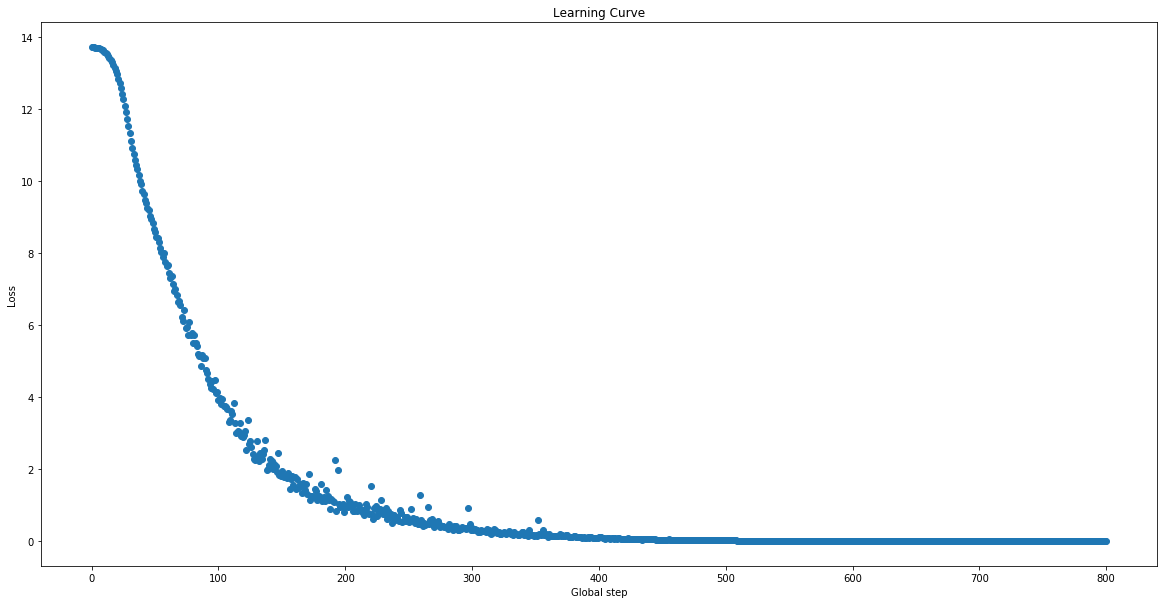

In [26]:
plt.figure(figsize=(20, 10))
plt.scatter(range(model.n_epoch), loss_history)
plt.title('Learning Curve')
plt.xlabel('Global step')
plt.ylabel('Loss')
plt.show()

In [27]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = seq2seqModel(config, mode='inference')
    model.build()
    for input_batch, target_batch in zip(input_batches, target_batches):
        data = (input_batch, target_batch)
        model.inference(sess, data, load_ckpt=model.ckpt_path+'epoch_'+str(model.n_epoch))


INFO:tensorflow:Restoring parameters from ./ckpt_dir_seqepoch_801
Restore Finished!
Input: Hi What is your name?
Prediction: GO Hi this is Jaemin . . . . .
Target: Hi this is Jaemin. 

Input: Nice to meet you!
Prediction: GO Nice to meet you too ! ! ! !
Target: Nice to meet you too! 

INFO:tensorflow:Restoring parameters from ./ckpt_dir_seqepoch_801
Restore Finished!
Input: Which programming language do you use?
Prediction: GO I like Python . . . . . .
Target: I like Python. 

Input: See you later.
Prediction: GO Bye Bye . . . . . . .
Target: Bye Bye. 

INFO:tensorflow:Restoring parameters from ./ckpt_dir_seqepoch_801
Restore Finished!
Input: Where do you live?
Prediction: GO I live in Seoul , South Korea . .
Target: I live in Seoul, South Korea. 

Input: What is your major?
Prediction: GO I study industrial engineering . . . . .
Target: I study industrial engineering. 

INFO:tensorflow:Restoring parameters from ./ckpt_dir_seqepoch_801
Restore Finished!
Input: What do you want to drink

In [29]:
import numpy as np

In [30]:
test = np.random.randint(1, high=22, size=[22])

In [31]:
test

array([ 6, 13, 11,  1, 16,  9, 17,  6,  8,  5, 10, 10, 13,  7,  7, 16, 19,
       15,  3, 18,  7, 11])

In [32]:
sess = tf.Session()

In [33]:
# x has shape [2, 3, 2]
x = tf.constant([[[1., 2.], [3., 4. ], [5. , 6. ]],
                 [[7., 8.], [9., 10.], [11., 12.]]])

In [34]:
x.shape

TensorShape([Dimension(2), Dimension(3), Dimension(2)])

In [35]:
x[:,1,:]

<tf.Tensor 'strided_slice_1:0' shape=(2, 2) dtype=float32>

In [36]:
x.eval(session=sess)

array([[[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.]],

       [[ 7.,  8.],
        [ 9., 10.],
        [11., 12.]]], dtype=float32)

In [37]:
x[:,1,:].eval(session=sess)

array([[ 3.,  4.],
       [ 9., 10.]], dtype=float32)

In [38]:
tf.slice(x,[0,0,0],[-1,1,2]).eval(session=sess)

array([[[1., 2.]],

       [[7., 8.]]], dtype=float32)

In [ ]:
y = tf.constant(np.reshape(test,(2,-1)))

In [ ]:
y.eval(session=sess)

In [ ]:
tf.slice(y,[0,0],[-1,8]).eval(session=sess)